In [2]:
import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import sys
sys.path.append('../')
import commons as cm
from data_curation import Normalization
# from pandasql import sqldf
import pupillometry_commons as cp
from pyplr import graphing
from pyplr import preproc
from pyplr import utils
from itertools import compress

nm=Normalization()

session_location = Path(r"D:/sessions")
sessions=[]
df_list=[]
windows_s=3
seconds_norm=0.05
with open('session.txt','r') as f:
    for session in f:
            sessions.append(session.replace('\n',''))
f.close()

session_loc_list=[session_location.joinpath(session,'01 Processing_data','pupil_labs') for session in sessions ]
session_raw_list=[session_location.joinpath(session, '00 Raw_data','pupil_labs') for session in sessions ]

image_loc_list=[session_location.joinpath(session,'images_order') for session in sessions ]

for subject, recording_location in zip(sessions,session_loc_list):
    recording_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    print(recording_folder)
    index_aux = list(map(lambda x: '_' not in x, recording_folder))
    recording_folder=list(compress(recording_folder,index_aux))
    #Load data in folders
    if len(recording_folder)>1:
        ValueError('Ambiguty in folder of experiment')
    recording_location=recording_location.joinpath(recording_folder[0],'exports')
    recording_location_raw=recording_location.joinpath(recording_folder[0],'exports')
    export_folder=[record for record in os.listdir(recording_location)  if '00' in record]
    if len(export_folder)>1:
        ValueError('Ambiguty in folder of exports')
    recording_location=recording_location.joinpath(export_folder[0])

    gaze_surf_csv=[record for record in os.listdir(recording_location.joinpath('surfaces'))  if 'gaze_positions' in record][0]

    print(f'Analixing session: {subject}')

    exported_pupil_csv = recording_location.joinpath('pupil_positions.csv')
    pupil_pd_frame = pd.read_csv(exported_pupil_csv)
    exported_gaze_csv = os.path.join(recording_location,'gaze_positions.csv')
    gaze_pd_frame = pd.read_csv(exported_gaze_csv)
    annotations_csv = os.path.join(recording_location,'annotations.csv')
    annotations_pd = pd.read_csv(annotations_csv)
    surface_gaze_csv = os.path.join(recording_location, 'surfaces',gaze_surf_csv)
    surfaces_pd_frame = pd.read_csv(surface_gaze_csv)

['ES0001_S020_Script.txt', '001']
Analixing session: ES0001_S020_PC_EM


In [78]:
rec_dir='D:/sessions/ES0001_S026_PC_EM/01 Processing_data/pupil_labs/004'

In [79]:

# Pupil Labs recording directory
utils.print_file_structure(rec_dir)

004/
    annotation.pldata
    annotation_player.pldata
    annotation_player_timestamps.npy
    annotation_timestamps.npy
    eye0.intrinsics
    eye0.mp4
    eye0_lookup.npy
    eye0_timestamps.npy
    eye1.intrinsics
    eye1.mp4
    eye1_lookup.npy
    eye1_timestamps.npy
    gaze.pldata
    gaze_timestamps.npy
    info.player.json
    notify.pldata
    notify_timestamps.npy
    pupil.pldata
    pupil_timestamps.npy
    square_marker_cache
    surface_definitions_v01
    user_info.csv
    world.intrinsics
    world.mp4
    world_lookup.npy
    world_timestamps.npy
    exports/
        001/
            annotations.csv
            export_info.csv
            fixation_report.csv
            fixations.csv
            gaze_positions.csv
            pupil_gaze_positions_info.txt
            pupil_positions.csv
            surfaces/
                fixations_on_surface_Surface 1.csv
                gaze_positions_on_surface.csv
                heatmap_Surface 1.png
                marker_

In [75]:

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='001', out_dir_nm='pyplr_analysis')

# Load pupil data
samples = utils.load_pupil(
    s['data_dir'], eye_id='best', cols=use_cols,method='pye3d 0.3.0 real-time')
samples

************************************************************
*************************** 004 ****************************
************************************************************
Loaded 78272 samples


,eye_id,confidence,diameter,method,diameter_3d
pupil_timestamp,,,,,
15326.103275,0,1.000000,36.173767,pye3d 0.3.0 real-time,4.057869
15326.111237,0,1.000000,36.148824,pye3d 0.3.0 real-time,4.054806
15326.119256,0,1.000000,36.624511,pye3d 0.3.0 real-time,4.106385
15326.127281,0,1.000000,36.730504,pye3d 0.3.0 real-time,4.128706
15326.135253,0,0.990000,36.540908,pye3d 0.3.0 real-time,4.143274
...,...,...,...,...,...
15957.667748,0,0.158420,32.498328,pye3d 0.3.0 real-time,2.760271
15957.675744,0,0.196504,33.275994,pye3d 0.3.0 real-time,2.797689
15957.683724,0,0.173101,35.532500,pye3d 0.3.0 real-time,2.974511


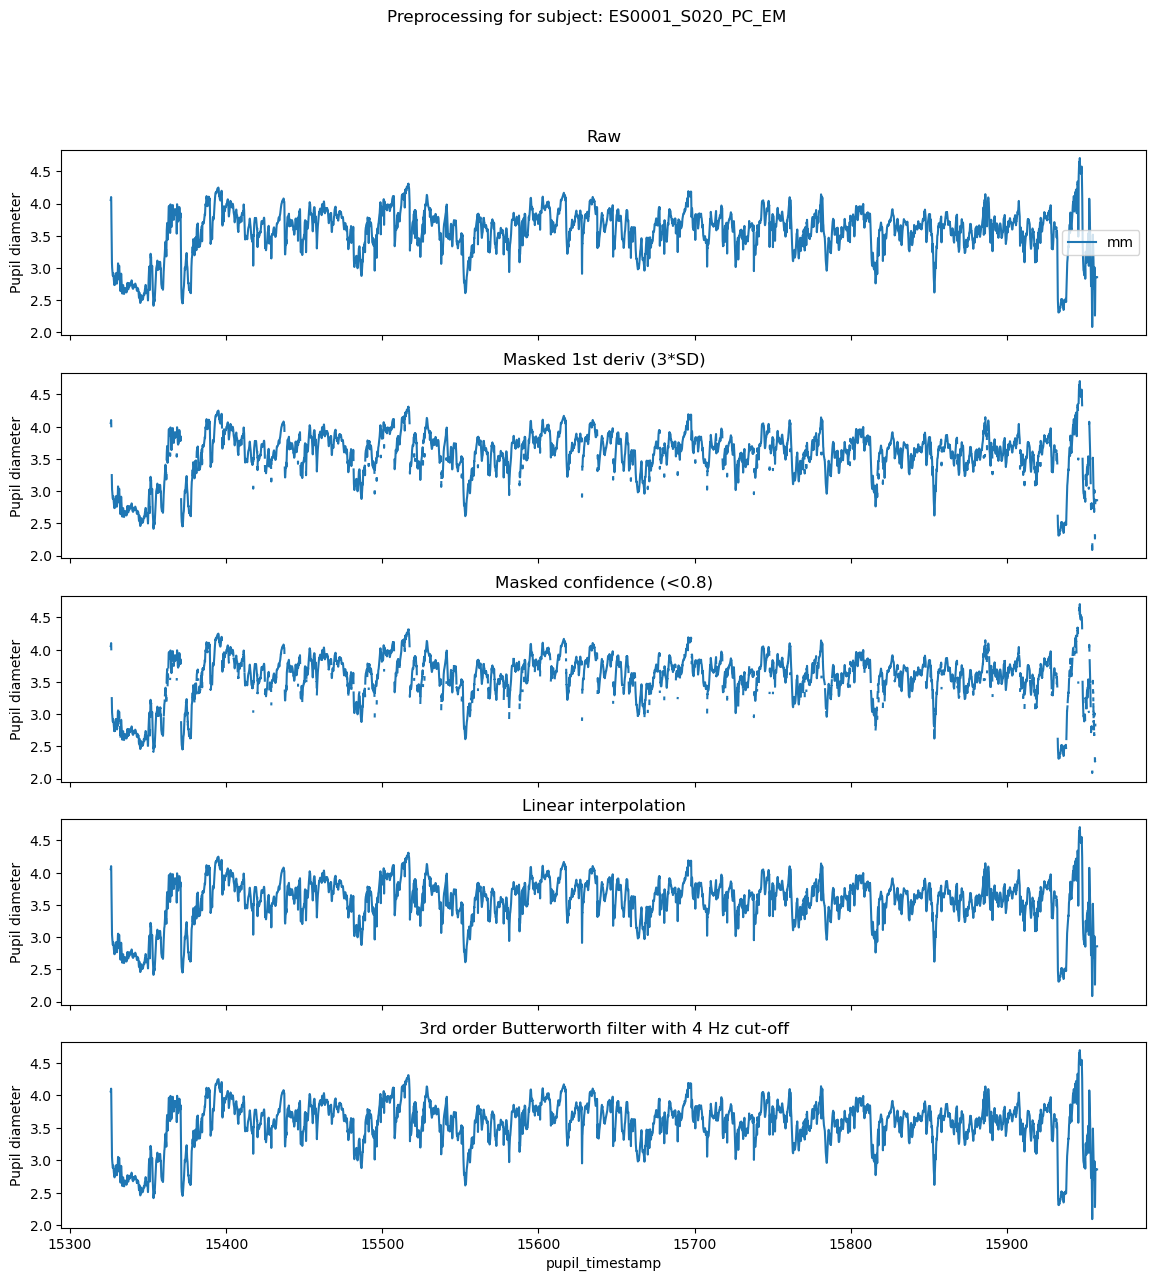

In [80]:

# Sampling frequency
SAMPLE_RATE = 122

# Pupil columns to analyse
pupil_cols = ['diameter_3d']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=subject)

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

### Asses data quality
Exclude experiments with a lot of blinks

In [32]:
    ##  Explore blinks and Asses data quality, are there many regions with data gaps? 
    parts = list(recording_location.parts)
    parts=parts[0:-2]
    parts=Path(*parts)
    f = open(parts.joinpath('info.player.json'))
    data = json.load(f)
    time_whole_recording=data['duration_s']
    time_roi_left=abs(pupil_left_eye['pupil_timestamp'].values[-1]-pupil_left_eye['pupil_timestamp'].values[0])
    time_roi_right=abs(pupil_right_eye['pupil_timestamp'].values[-1]-pupil_right_eye['pupil_timestamp'].values[0])

    pupil_sampling_freq_left=(pupil_left_eye.shape[0]+blinks_left_eye.shape[0])/time_roi_left
    pupil_sampling_freq_right=(pupil_right_eye.shape[0]+blinks_right_eye.shape[0])/time_roi_right 
    print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
    print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 
    # Closing file
    f.close()

    ### Asses data quality
    total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
    total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
    print(f'Total blinks time left {total_blinks_left:.2f}s and right {total_blinks_right:.2f}s of a total of {time_roi_left:.2f}s left and {time_roi_right:.2f}s right')
    print(f'Total blinks time left {total_blinks_left/time_roi_left:.2%} ')
    print(f'Total blinks time right {total_blinks_right/time_roi_right:.2%} ')


,eye_id,confidence,diameter,method,diameter_3d,interpolated,orig_idx
pupil_timestamp,,,,,,,
15326.103275,0,1.000000,36.169196,pye3d 0.3.0 real-time,4.056330,0,15326.103275
15326.111237,0,1.000000,36.025120,pye3d 0.3.0 real-time,4.057294,0,15326.111237
15326.119256,0,1.000000,35.881618,pye3d 0.3.0 real-time,4.058254,0,15326.119256
15326.127281,0,1.000000,35.739448,pye3d 0.3.0 real-time,4.059127,0,15326.127281
15326.135253,0,0.990000,35.599587,pye3d 0.3.0 real-time,4.059849,0,15326.135253
...,...,...,...,...,...,...,...
15957.667748,0,0.158420,25.734987,pye3d 0.3.0 real-time,2.857844,1,15957.667748
15957.675744,0,0.196504,25.734987,pye3d 0.3.0 real-time,2.857844,1,15957.675744
15957.683724,0,0.173101,25.734987,pye3d 0.3.0 real-time,2.857844,1,15957.683724


In [55]:
events = utils.load_annotations(s['data_dir'])
filter_assets=events['label'].str.contains('Surprise') 
events=events.loc[filter_assets]
events

Loaded 163 events


,index,label,duration
timestamp,,,
15481.065994,9200,Surprise04.tif,NaN
15591.249891,15776,Surprise02.tif,NaN
15681.400885,21157,Surprise01.tif,NaN
15801.586764,28329,Surprise03.tif,NaN


In [73]:
# Number of samples to extract and which sample
# should mark the onset of the event
DURATION = 260
ONSET_IDX = 6

# Extract the event ranges
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

Extracted ranges for 4 events


eye_id  confidence   diameter                 method  \
event onset                                                         
0     0           0    0.219117  33.712172  pye3d 0.3.0 real-time   
      1           0    0.205689  33.699137  pye3d 0.3.0 real-time   
      2           0    0.410953  33.688088  pye3d 0.3.0 real-time   
      3           0    0.425211  33.679557  pye3d 0.3.0 real-time   
      4           0    0.412943  33.674081  pye3d 0.3.0 real-time   
...             ...         ...        ...                    ...   
3     255         0    1.000000  38.315472  pye3d 0.3.0 real-time   
      256         0    1.000000  38.314775  pye3d 0.3.0 real-time   
      257         0    1.000000  38.316371  pye3d 0.3.0 real-time   
      258         0    1.000000  38.320018  pye3d 0.3.0 real-time   
      259         0    1.000000  38.325420  pye3d 0.3.0 real-time   

             diameter_3d  interpolated      orig_idx  color  
event onset                                                  
0     0         3.501193             1  15481.019396    NaN  
      1         3.500309             1  15481.027386    NaN  
      2         3.499523             1  15481.035375    NaN  
      3         3.498865             1  15481.043402    NaN  
      4         3.498368             1  15481.051396    NaN  
...                  ...           ...           ...    ...  
3     255       3.949820             0  15803.599698    NaN  
      256       3.949593             0  15803.607681    NaN  
      257       3.949449             0  15803.615684    NaN  
      258       3.949383             0  15803.623695    NaN  
      259       3.949388             0  15803.631712    NaN  

[1040 rows x 8 columns]

In [69]:
# Calculate baselines
baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

# New columns for percent signal change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

C:\Users\Bolo\AppData\Local\Temp\ipykernel_8816\2102182471.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)
C:\Users\Bolo\AppData\Local\Temp\ipykernel_8816\2102182471.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)


eye_id  confidence   diameter                 method  \
event onset                                                         
0     0           0    0.219117  33.712172  pye3d 0.3.0 real-time   
      1           0    0.205689  33.699137  pye3d 0.3.0 real-time   
      2           0    0.410953  33.688088  pye3d 0.3.0 real-time   
      3           0    0.425211  33.679557  pye3d 0.3.0 real-time   
      4           0    0.412943  33.674081  pye3d 0.3.0 real-time   
...             ...         ...        ...                    ...   
3     255         0    1.000000  38.315472  pye3d 0.3.0 real-time   
      256         0    1.000000  38.314775  pye3d 0.3.0 real-time   
      257         0    1.000000  38.316371  pye3d 0.3.0 real-time   
      258         0    1.000000  38.320018  pye3d 0.3.0 real-time   
      259         0    1.000000  38.325420  pye3d 0.3.0 real-time   

             diameter_3d  interpolated      orig_idx  color  diameter_3d_pc  
event onset                                                                  
0     0         3.501193             1  15481.019396    NaN        0.051599  
      1         3.500309             1  15481.027386    NaN        0.026343  
      2         3.499523             1  15481.035375    NaN        0.003885  
      3         3.498865             1  15481.043402    NaN       -0.014916  
      4         3.498368             1  15481.051396    NaN       -0.029131  
...                  ...           ...           ...    ...             ...  
3     255       3.949820             0  15803.599698    NaN        4.051300  
      256       3.949593             0  15803.607681    NaN        4.045307  
      257       3.949449             0  15803.615684    NaN        4.041521  
      258       3.949383             0  15803.623695    NaN        4.039796  
      259       3.949388             0  15803.631712    NaN        4.039926  

[1040 rows x 9 columns]

In [67]:
from pyplr.plr import PLR

average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=SAMPLE_RATE,
          onset_idx=ONSET_IDX,
          stim_duration=1)



C:\Users\Bolo\AppData\Local\Temp\ipykernel_8816\3953476756.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
C:\Users\Bolo\AppData\Local\Temp\ipykernel_8816\3953476756.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()


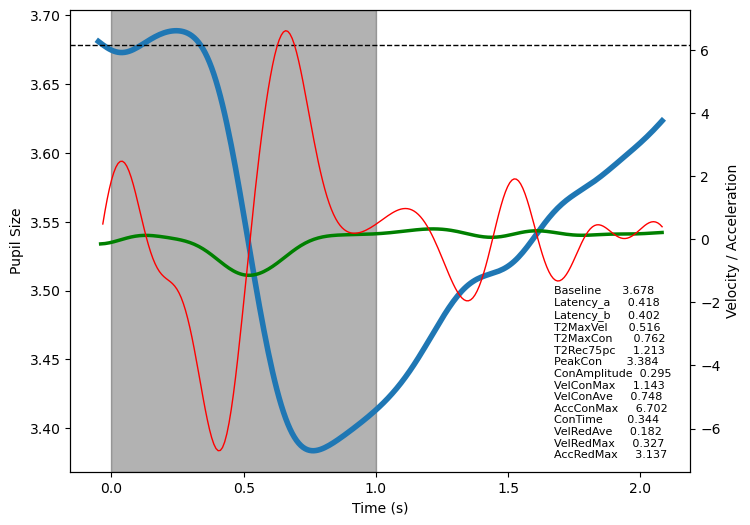

In [72]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [54]:
params = plr.parameters()
params

,value
Baseline,3.690715
Latency_a,0.565574
Latency_b,0.418033
T2MaxVel,0.540984
T2MaxCon,0.975410
T2Rec75pc,0.540984
PeakCon,3.612094
ConAmplitude,0.078621
VelConMax,0.295935
VelConAve,0.103149


In [60]:
params = plr.parameters()
params

,value
Baseline,3.678159
Latency_a,0.418033
Latency_b,0.401639
T2MaxVel,0.516393
T2MaxCon,0.762295
T2Rec75pc,1.213115
PeakCon,3.383655
ConAmplitude,0.294504
VelConMax,1.143364
VelConAve,0.748198


In [ ]:

best = samples.groupby(['eye_id'])['confidence'].mean().idxmax()
best

In [ ]:
from pyplr import graphing
from pyplr import preproc
from pyplr import utils

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

pupil_left_eye_interpolated=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1)]
samples=pupil_left_eye_interpolated


In [ ]:

# Load pupil data
SAMPLE_RATE = 123.93247405412919

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject='Example')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=1, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


In [ ]:
%matplotlib qt
samples['diameter_3d'].plot()

In [ ]:
# samples.shape[0]
pupil_pd_frame.shape[0]

In [ ]:
# Pupil Labs recording directory
rec_dir = 'P:/Proyectos/2020/PY200016 - XSCAPE/Trabajo/00 XPERIMENTS/01 EXPERIMENTS_Santiago/01 ONGOING/Exp_Stgo_0001/SESSIONS/ES0001_S006_PC_EM/01 Processing_data/pupil_labs/007'
utils.print_file_structure(rec_dir)

In [ ]:
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

# Load pupil data
samples = utils.load_pupil(
    s['data_dir'], eye_id='best',method='pye3d 0.3.0 real-time', cols=use_cols)
samples

In [ ]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject='Example')

# Plot the raw data
samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);


In [ ]:
events = utils.load_annotations(s['data_dir'])
events

In [ ]:
# Number of samples to extract and which sample
# should mark the onset of the event
DURATION = 300
ONSET_IDX = 600

# Extract the event ranges
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])
ranges

In [ ]:
# Calculate baselines
baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

# New columns for percent signal change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

In [ ]:
from pyplr.plr import PLR

average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=SAMPLE_RATE,
          onset_idx=ONSET_IDX,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)
